In [1]:
import sys, os
sys.path.insert(0, '..')

In [2]:
import graph_tool.all as gt
import graph_embeddings
from models.crosswalk import Crosswalk
from utils.score import statistical_parity
import faiss
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder



Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-08-14 01:55:09.342716: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-08-14 01:55:09.362284: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304000000 Hz
2022-08-14 01:55:09.363077: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b8dcd7b000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-14 01:55:09.363087: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-14 01:55:09

In [3]:

DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)

models = {}
window_length = 5
num_walks = 10
dim = 128

models["baseline"] = graph_embeddings.DeepWalk(window_length=window_length, num_walks=num_walks, restart_prob=0)

models["degree-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80
)

models["group-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

models["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks)
models["fairwalk-group"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
)
models['GCN'] = graph_embeddings.GCN()
models["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2)
models["graphsage"] = graph_embeddings.GraphSage()
models["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2)
models["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256])
models["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2)

models['crosswalk'] = Crosswalk(group_membership=group_ids, window_length=window_length, num_walks=num_walks)

In [4]:
A[0:].todense(), A.shape

(matrix([[0., 1., 1., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.]]),
 (105, 105))

In [5]:
embs = {}

for k, model in tqdm(models.items()):
    print(model.__class__.__name__)
#     sys.stdout = open(os.devnull, 'w')
    
    if "unbiased" in k:
        from residual2vec.word2vec import Word2Vec
        m = Word2Vec(vocab_size=A.shape[0] + 1, embedding_size=dim, padding_idx=A.shape[0])
        emb = model.fit(A).transform(m)
    else:    
        emb = model.fit(A).transform(dim=dim)
#     sys.stdout = sys.__stdout__
    embs[k] = emb

  8%|████████                                                                                        | 1/12 [00:00<00:01,  7.37it/s]

DeepWalk
residual2vec_sgd



  0%|                                                                                            | 0/329 [00:00<?, ?it/s, loss=1.13]


 30%|████████████████████████▌                                                        | 100/329 [00:00<00:00, 321.97it/s, loss=1.17]


 30%|████████████████████████▌                                                        | 100/329 [00:00<00:00, 321.97it/s, loss=1.01]


 61%|█████████████████████████████████████████████████▏                               | 200/329 [00:00<00:00, 365.80it/s, loss=1.06]


 61%|█████████████████████████████████████████████████▏                               | 200/329 [00:00<00:00, 365.80it/s, loss=1.03]


 17%|████████████████                                                                                | 2/12 [00:05<00:34,  3.48s/it]

residual2vec_sgd



  0%|                                                                                            | 0/329 [00:00<?, ?it/s, loss=1.35]


 30%|████████████████████████▌                                                        | 100/329 [00:00<00:00, 356.36it/s, loss=1.29]


 30%|████████████████████████▌                                                        | 100/329 [00:00<00:00, 356.36it/s, loss=1.29]


 61%|█████████████████████████████████████████████████▏                               | 200/329 [00:00<00:00, 386.39it/s, loss=1.28]


 61%|█████████████████████████████████████████████████▏                               | 200/329 [00:00<00:00, 386.39it/s, loss=1.27]


 25%|████████████████████████                                                                        | 3/12 [00:06<00:21,  2.34s/it]

Fairwalk


 42%|████████████████████████████████████████                                                        | 5/12 [00:07<00:07,  1.03s/it]

Fairwalk
GCN
Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export

Epoch 50/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 51/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0071 - val_loss: 0.0113
Epoch 52/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0071 - val_loss: 0.0113
Epoch 53/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0068 - val_loss: 0.0114
Epoch 54/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0068 - val_loss: 0.0114
Epoch 55/200
1/1 [==============================] - 0s 60ms/step - loss: 0.0068 - val_loss: 0.0115
Epoch 56/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0068 - val_loss: 0.0115
Epoch 57/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0065 - val_loss: 0.0115
Epoch 58/200
1/1 [==============================] - 0s 39ms/step - loss: 0.0066 - val_loss: 0.0115
Epoch 59/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0065 - val_loss: 0.0117
Epoch 60/2

 50%|████████████████████████████████████████████████                                                | 6/12 [00:14<00:19,  3.17s/it]

GCN
Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAP

1/1 [==============================] - 0s 85ms/step - loss: 0.0073 - val_loss: 0.0111
Epoch 51/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0069 - val_loss: 0.0111
Epoch 52/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0068 - val_loss: 0.0112
Epoch 53/200
1/1 [==============================] - 0s 51ms/step - loss: 0.0068 - val_loss: 0.0113
Epoch 54/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0067 - val_loss: 0.0114
Epoch 55/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0066 - val_loss: 0.0116
Epoch 56/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0069 - val_loss: 0.0116
Epoch 57/200
1/1 [==============================] - 0s 51ms/step - loss: 0.0068 - val_loss: 0.0118
Epoch 58/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0068 - val_loss: 0.0120
Epoch 59/200
1/1 [==============================] - 0s 60ms/step - loss: 0.0065 - val_loss: 0.0120
Epoch 60/200
1/1 [=====

 58%|████████████████████████████████████████████████████████                                        | 7/12 [00:22<00:22,  4.60s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-14 01:55:34.058595: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 565ms/step - loss: 0.7032 - binary_accuracy: 0.5000
Epoch 3/5


2022-08-14 01:55:34.680971: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 581ms/step - loss: 0.6738 - binary_accuracy: 0.5048
Epoch 4/5


2022-08-14 01:55:35.356511: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 638ms/step - loss: 0.6314 - binary_accuracy: 0.6952
Epoch 5/5


2022-08-14 01:55:35.991892: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 685ms/step - loss: 0.6257 - binary_accuracy: 0.6810


2022-08-14 01:55:36.620881: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 176ms/step


2022-08-14 01:55:37.178238: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
 67%|████████████████████████████████████████████████████████████████                                | 8/12 [00:27<00:18,  4.74s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-14 01:55:39.044355: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 589ms/step - loss: 0.7083 - binary_accuracy: 0.5000
Epoch 3/5


2022-08-14 01:55:39.700936: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 668ms/step - loss: 0.6849 - binary_accuracy: 0.5095
Epoch 4/5


2022-08-14 01:55:40.366267: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 681ms/step - loss: 0.6569 - binary_accuracy: 0.5857
Epoch 5/5


2022-08-14 01:55:41.012271: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 612ms/step - loss: 0.6404 - binary_accuracy: 0.6286


2022-08-14 01:55:41.643383: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 179ms/step


2022-08-14 01:55:42.207188: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
 75%|████████████████████████████████████████████████████████████████████████                        | 9/12 [00:32<00:14,  4.83s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Epoch 50/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 51/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 52/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 53/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 54/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 55/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 56/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 57/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 58/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 59/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 60/2

 83%|███████████████████████████████████████████████████████████████████████████████▏               | 10/12 [00:42<00:13,  6.63s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Epoch 50/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0087 - val_loss: 0.0098
Epoch 51/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 52/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 53/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 54/200
1/1 [==============================] - 0s 102ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 55/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 56/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 57/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 58/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 59/200
1/1 [==============================] - 0s 85ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 60/

 92%|███████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:56<00:08,  8.61s/it]

Crosswalk


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:58<00:00,  4.90s/it]


In [6]:

def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)



In [7]:
n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [8]:
scores = {}
for k, graph in rgraphs.items():
    scores[k] = statistical_parity(graph, group_ids)
    print("class score: ", k, scores[k])

class score:  baseline 0.15771529989246091
class score:  degree-unbiased 0.14310928612263124
class score:  group-unbiased 0.10755198280251148
class score:  fairwalk 0.15069623931546958
class score:  fairwalk-group 0.17069608311210605
class score:  GCN 0.17295492486654393
class score:  gcn-doubleK 0.1461945041376309
class score:  graphsage 0.12827708399394763
class score:  graphsage-doubleK 0.08765276493584036
class score:  gat 0.1789087070855444
class score:  gat-doubleK 0.17052140065348986
class score:  crosswalk 0.09709847426981622


[Text(0,0,'baseline'),
 Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK'),
 Text(0,0,'crosswalk')]

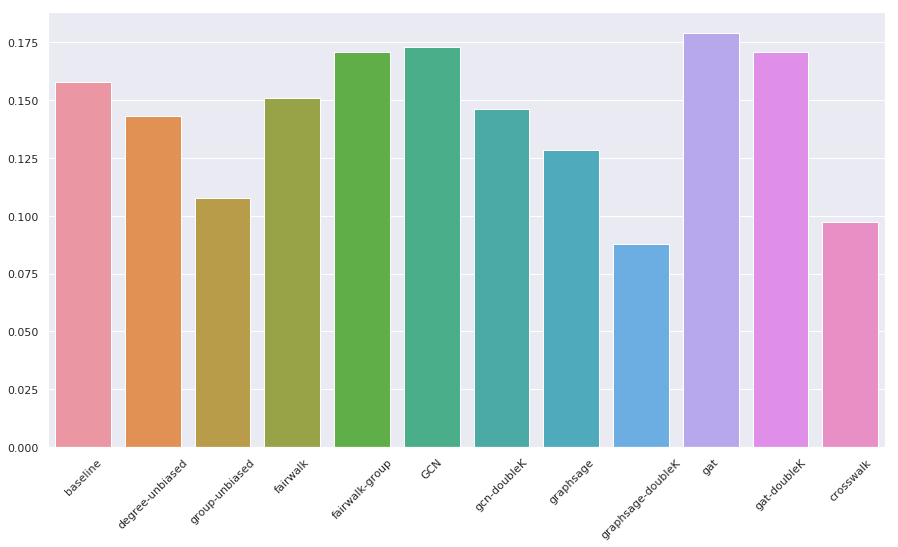

In [9]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [10]:
import pickle as pkl
pkl.dump(rgraphs, open('/tmp/rgraphs.pkl', 'wb'))
pkl.dump(group_ids, open('/tmp/group_ids.pkl', 'wb'))
pkl.dump(embs, open('/tmp/embs.pkl', 'wb'))


In [11]:
# check shapes of different properties of the r2v
model = models['degree-unbiased']

In [12]:
type(model)

residual2vec.residual2vec_sgd.residual2vec_sgd

In [13]:
model.in_vec.shape, model.out_vec.shape

((105, 128), (105, 128))